<a href="https://colab.research.google.com/github/sai-23may/Text-To-Image/blob/main/text_to_image_synthesizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Necessary imports
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np

from urllib.request import urlopen

In [ ]:
# Load Glove Function
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [ ]:
glove_embeddings = loadGloveModel("/content/drive/MyDrive/package stuff/Package/embeddings/glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [ ]:
# Setting up the paths
train_data_path = "/content/drive/MyDrive/package stuff/Package/flowers_data/flowers"
train_images_path = "/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/images/jpg/jpg"
train_captions_path = "/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10"

The following packages will be used to implement a basic GAN system in Python/Keras.

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
# Formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
GENERATE_RES = 4 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 300

# Configuration
DATA_PATH = train_images_path
MODEL_PATH = "/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/model"
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 128px square images.


## Data Pre-Processing 

Next we will load and preprocess the images.  This can take awhile.  Google CoLab took around an hour to process.  Because of this we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [ ]:
# Image set has 8,188 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.

training_binary_path = os.path.join("/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/images/npy64",
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))
print(flowers_path)
for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    # print(path)
    try:
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_data) == 100:
      training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
      training_data = training_data.astype(np.float32)
      #Normalizing the input
      training_data = training_data / 127.5 - 1.

      print("Saving training image " + str(100000 + filename) + ".npy")
      np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
      elapsed = time.time()-start
      print (f'Image preprocess time: {hms_string(elapsed)}')
      training_data = []
print("Complete")

Loading training images...
['image_00001.jpg', 'image_00002.jpg', 'image_00003.jpg', 'image_00004.jpg', 'image_00005.jpg', 'image_00006.jpg', 'image_00007.jpg', 'image_00008.jpg', 'image_00009.jpg', 'image_00010.jpg', 'image_00011.jpg', 'image_00012.jpg', 'image_00013.jpg', 'image_00014.jpg', 'image_00015.jpg', 'image_00016.jpg', 'image_00017.jpg', 'image_00018.jpg', 'image_00019.jpg', 'image_00020.jpg', 'image_00021.jpg', 'image_00022.jpg', 'image_00023.jpg', 'image_00024.jpg', 'image_00025.jpg', 'image_00026.jpg', 'image_00027.jpg', 'image_00028.jpg', 'image_00029.jpg', 'image_00030.jpg', 'image_00031.jpg', 'image_00032.jpg', 'image_00033.jpg', 'image_00034.jpg', 'image_00035.jpg', 'image_00036.jpg', 'image_00037.jpg', 'image_00038.jpg', 'image_00039.jpg', 'image_00040.jpg', 'image_00041.jpg', 'image_00042.jpg', 'image_00043.jpg', 'image_00044.jpg', 'image_00045.jpg', 'image_00046.jpg', 'image_00047.jpg', 'image_00048.jpg', 'image_00049.jpg', 'image_00050.jpg', 'image_00051.jpg', 'im

Next we will load and preprocess the captions. This can take awhile. Google CoLab took around an hour to process. Because of this we store the processed file as a binary. This way we can simply reload the processed data and quickly use it. It is most efficient to only perform this operation once.

In [ ]:
import glob
import pathlib

In [ ]:
text_path = "/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10"

l = []
ps = {}
for root, dirs, files in os.walk("/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10"):
    for file in files:
        if file.endswith(".txt"):
             #print(file)
             l.append(file)
             ps[file] = os.path.join(root, file)

text_files = sorted(l)
captions = []
caption_embeddings = np.zeros((len(text_files),300),dtype=np.float32)
for filename in range(len(text_files)):
    path = ps[text_files[filename]]
    print(path)
    f = open(path,'r')
    data = f.read()
    data = data.split("\n")
    f.close()
    for d in range(1):
      x = data[d].lower()
      #x = x.replace(" ","")
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          print(t)
          pass
      caption_embeddings[filename] /= count
    if filename %100 == 0:
      print("-------------Files completed:",filename)

Streaming output truncated to the last 5000 lines.
 
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/class_00098/image_07818.txt
 
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/class_00098/image_07819.txt
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/class_00098/image_07820.txt
 
 
 
 
 
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/class_00098/image_07821.txt
 
 
 
 
 
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/class_00098/image_07822.txt
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/class_00098/image_07823.txt
 
 
 
 
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/class_00098/image_07824.txt
 
 
 
 
 
 
 
 
 
 
 
 
 
/content/drive/MyDrive/p

In [ ]:
# saving the caption embeddings numpy
#embedding_binary_path = os.path.join('/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/images/embedding_npy',
#        f'embedding_data_character.npy')
# print("Saving captions embeddings binary...")
# np.save(embedding_binary_path,caption_embeddings)

In [ ]:
# saving the caption embeddings numpy
embedding_binary_path = os.path.join('/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/images/embedding_npy',
        f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

Saving captions embeddings binary...


In [ ]:
# Creating a dataframe to store the captions
df_captions = pd.DataFrame([])
df_captions['captions'] = captions[:len(final_images)]

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


In [ ]:
captions[:10]

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.']

In [ ]:
df_captions.to_csv("/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/captions.csv",index=None)

## Loading and combining numpys

In [ ]:
embedding_binary_path = os.path.join('/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/images/embedding_npy',
        f'embedding_data.npy')

In [ ]:
caption_embeddings = np.load(embedding_binary_path)

In [ ]:
print(caption_embeddings)

[[-0.2877301  -0.00107474 -0.2072907  ... -0.53047097 -0.07935404
   0.16945915]
 [-0.26723632  0.03717088 -0.30101988 ... -0.54951364 -0.09020615
   0.14092845]
 [-0.3756713   0.02952076 -0.30324548 ... -0.56901705 -0.23083352
   0.06800084]
 ...
 [-0.25845718  0.04322989 -0.31873155 ... -0.53846526 -0.02812552
   0.1592929 ]
 [-0.28574035  0.02204715 -0.30363196 ... -0.5614028  -0.06559128
   0.1988871 ]
 [-0.29051405  0.03127474 -0.36992636 ... -0.5526128  -0.05409274
   0.11360314]]


In [ ]:
caption_embeddings.shape

(8189, 300)

In [ ]:
image_binary_path = "/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/images/npy64"
images = os.listdir(image_binary_path)

In [ ]:
images[-1]

'training_data_64_64_108099.npy'

In [ ]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path +"/"+ images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + "/" + i)],axis = 0)
  except:
    pass

training_data_64_64_100199.npy
training_data_64_64_100299.npy
training_data_64_64_100399.npy
training_data_64_64_100499.npy
training_data_64_64_100599.npy
training_data_64_64_100699.npy
training_data_64_64_100799.npy
training_data_64_64_100899.npy
training_data_64_64_100999.npy
training_data_64_64_101099.npy
training_data_64_64_101199.npy
training_data_64_64_101299.npy
training_data_64_64_101399.npy
training_data_64_64_101499.npy
training_data_64_64_101599.npy
training_data_64_64_101699.npy
training_data_64_64_101799.npy
training_data_64_64_101899.npy
training_data_64_64_101999.npy
training_data_64_64_102099.npy
training_data_64_64_102199.npy
training_data_64_64_102299.npy
training_data_64_64_102399.npy
training_data_64_64_102499.npy
training_data_64_64_102599.npy
training_data_64_64_102699.npy
training_data_64_64_102799.npy
training_data_64_64_102899.npy
training_data_64_64_102999.npy
training_data_64_64_103099.npy
training_data_64_64_103199.npy
training_data_64_64_103299.npy
training

In [ ]:
final_images.shape

(8100, 64, 64, 3)

In [ ]:
df_captions = pd.read_csv("/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/text_c10/captions.csv")

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


In [ ]:
captions = list(df_captions.captions)

In [ ]:
len(captions)

8100

Saved images separately for testing

In [ ]:
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

In [ ]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]

In [ ]:
caption_embeddings.shape

(8100, 300)

Shuffling the data

In [ ]:
p = np.random.permutation(len(final_images))

In [ ]:
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]

In [ ]:
final_images_shuffled.shape

(8100, 64, 64, 3)

In [ ]:
final_embeddings_shuffled.shape

(8100, 300)

In [ ]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
#     .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Data Modeling

Defining the Generator and Discriminator

In [ ]:
def build_generator_func(seed_size,embedding_size, channels):
  input_seed = Input(shape=seed_size)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  return model

def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  return model

Function to save image samples generated

In [ ]:
def save_images(cnt,noise,embeds):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = "/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/output"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
# Initlializing a generator
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
try:
  generator.load_weights("/content/drive/MyDrive/package stuff/Package/flowers_data/flowers/model/text_to_image_generator_cub_character.h5")
except:
  print("No loading previous model")

No loading previous model


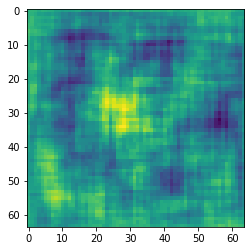

In [ ]:
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)
try:
  discriminator.load_weights((os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5")))
except:
  print("No loading previous model")

No loading previous model


In [ ]:
decision = discriminator((generated_image,caption_embeddings[5].reshape(1,300)))
print(decision)

tf.Tensor([[0.50420207]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=2e-4,
#     decay_steps=100,
#     decay_rate=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

## Training

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
# Function that executes trianing process
def train(train_dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      # train_batch = training_data[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      # caption_batch = captions[BATCH_SIZE*image_batch : BATCH_SIZE*image_batch + BATCH_SIZE]
      train_batch = batch['images']
      caption_batch = batch['embeddings']
      
      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)
      
      t = train_step(train_batch,caption_batch,fake_caption_batch)
      # print(t)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
      # if image_batch%50 == 0:
      #   print(image_batch)
      # print("here")
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)
    
    generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
    discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
    print("model saved")

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))


In [ ]:
train(list(train_dataset.as_numpy_iterator()), 500)

epoch start...
now
Epoch 1, gen loss=0.8042378425598145,disc loss=1.5411397218704224, 0:00:39.38
1/1 [==============================] - 1s 668ms/step


model saved
epoch start...
now
Epoch 2, gen loss=0.767966091632843,disc loss=1.475882887840271, 0:00:26.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 3, gen loss=0.756489634513855,disc loss=1.4433107376098633, 0:00:26.41
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 4, gen loss=0.7251661419868469,disc loss=1.4301210641860962, 0:00:26.71
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 5, gen loss=0.7257819771766663,disc loss=1.4230808019638062, 0:00:26.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 6, gen loss=0.7196142077445984,disc loss=1.424440622329712, 0:00:27.14
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 7, gen loss=0.7210082411766052,disc loss=1.414467215538025, 0:00:27.31
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 8, gen loss=0.7223443984985352,disc loss=1.4107998609542847, 0:00:27.40
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 9, gen loss=0.7226243019104004,disc loss=1.4037268161773682, 0:00:27.62
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 10, gen loss=0.7236652970314026,disc loss=1.3998404741287231, 0:00:27.79
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 11, gen loss=0.7293289303779602,disc loss=1.4008057117462158, 0:00:27.84
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 12, gen loss=0.7217816114425659,disc loss=1.3951359987258911, 0:00:27.88
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 13, gen loss=0.7124496102333069,disc loss=1.3938814401626587, 0:00:27.90
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 14, gen loss=0.719764232635498,disc loss=1.3898190259933472, 0:00:27.92
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 15, gen loss=0.7279662489891052,disc loss=1.3862278461456299, 0:00:27.94
1/1 [==============================] - 0s 37ms/step


model saved
epoch start...
now
Epoch 16, gen loss=0.7489538788795471,disc loss=1.3768579959869385, 0:00:27.99
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 17, gen loss=0.7548840641975403,disc loss=1.3783725500106812, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 18, gen loss=0.786339282989502,disc loss=1.3643593788146973, 0:00:28.02
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 19, gen loss=0.8024795055389404,disc loss=1.3680975437164307, 0:00:28.00
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 20, gen loss=0.813911497592926,disc loss=1.3533717393875122, 0:00:28.03
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 21, gen loss=0.8611844778060913,disc loss=1.3413877487182617, 0:00:27.95
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 22, gen loss=0.8934417366981506,disc loss=1.330482840538025, 0:00:27.89
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 23, gen loss=0.8994281888008118,disc loss=1.3359712362289429, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 24, gen loss=0.9316038489341736,disc loss=1.3315964937210083, 0:00:28.00
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 25, gen loss=0.993403971195221,disc loss=1.3136069774627686, 0:00:27.92
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 26, gen loss=0.9133796691894531,disc loss=1.3248039484024048, 0:00:27.90
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 27, gen loss=0.8989285230636597,disc loss=1.3335801362991333, 0:00:27.92
1/1 [==============================] - 0s 28ms/step


model saved
epoch start...
now
Epoch 28, gen loss=0.8205583691596985,disc loss=1.3647290468215942, 0:00:28.03
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 29, gen loss=0.77068692445755,disc loss=1.3804805278778076, 0:00:27.91
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 30, gen loss=0.8965424299240112,disc loss=1.3305572271347046, 0:00:27.87
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 31, gen loss=0.8675275444984436,disc loss=1.3405061960220337, 0:00:27.91
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 32, gen loss=0.8626976609230042,disc loss=1.3486319780349731, 0:00:27.96
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 33, gen loss=0.8811268210411072,disc loss=1.340262770652771, 0:00:27.99
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 34, gen loss=0.7863427400588989,disc loss=1.3712303638458252, 0:00:28.02
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 35, gen loss=0.7998825907707214,disc loss=1.3521876335144043, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 36, gen loss=0.7958579659461975,disc loss=1.361255168914795, 0:00:27.89
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 37, gen loss=0.7780841588973999,disc loss=1.3652559518814087, 0:00:27.95
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 38, gen loss=0.7729511857032776,disc loss=1.3669720888137817, 0:00:28.03
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 39, gen loss=0.7794730067253113,disc loss=1.365785002708435, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 40, gen loss=0.7383124828338623,disc loss=1.3801220655441284, 0:00:27.96
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 41, gen loss=0.7707042098045349,disc loss=1.3643475770950317, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 42, gen loss=0.7940827012062073,disc loss=1.3569368124008179, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 43, gen loss=0.7598670125007629,disc loss=1.3754669427871704, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 44, gen loss=0.7696905136108398,disc loss=1.3658206462860107, 0:00:27.99
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 45, gen loss=0.7517633438110352,disc loss=1.3702181577682495, 0:00:27.96
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 46, gen loss=0.7473941445350647,disc loss=1.3773592710494995, 0:00:27.96
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 47, gen loss=0.7345603108406067,disc loss=1.3782905340194702, 0:00:27.95
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 48, gen loss=0.747170090675354,disc loss=1.3721686601638794, 0:00:27.90
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 49, gen loss=0.7500725984573364,disc loss=1.3702516555786133, 0:00:27.91
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 50, gen loss=0.7660120129585266,disc loss=1.3655532598495483, 0:00:27.93
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 51, gen loss=0.7518526911735535,disc loss=1.3713399171829224, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 52, gen loss=0.7761656641960144,disc loss=1.3597253561019897, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 53, gen loss=0.7672286629676819,disc loss=1.3682284355163574, 0:00:27.95
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 54, gen loss=0.7558972239494324,disc loss=1.3692213296890259, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 55, gen loss=0.7581048607826233,disc loss=1.3678449392318726, 0:00:27.99
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 56, gen loss=0.7500280737876892,disc loss=1.3724621534347534, 0:00:27.91
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 57, gen loss=0.7456839680671692,disc loss=1.3727747201919556, 0:00:27.91
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 58, gen loss=0.7570732235908508,disc loss=1.3675082921981812, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 59, gen loss=0.7692566514015198,disc loss=1.3595430850982666, 0:00:27.92
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 60, gen loss=0.7731895446777344,disc loss=1.3641879558563232, 0:00:27.94
1/1 [==============================] - 0s 44ms/step


model saved
epoch start...
now
Epoch 61, gen loss=0.7696869969367981,disc loss=1.3600209951400757, 0:00:28.00
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 62, gen loss=0.7759078145027161,disc loss=1.3606194257736206, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 63, gen loss=0.7895050048828125,disc loss=1.3549832105636597, 0:00:27.92
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 64, gen loss=0.7593442797660828,disc loss=1.3683379888534546, 0:00:27.89
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 65, gen loss=0.7731497287750244,disc loss=1.3640333414077759, 0:00:27.92
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 66, gen loss=0.7923083901405334,disc loss=1.3520828485488892, 0:00:27.95
1/1 [==============================] - 0s 32ms/step


model saved
epoch start...
now
Epoch 67, gen loss=0.8466666340827942,disc loss=1.3342899084091187, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 68, gen loss=0.838383138179779,disc loss=1.3409650325775146, 0:00:27.98
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 69, gen loss=0.8216664791107178,disc loss=1.3511298894882202, 0:00:27.93
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 70, gen loss=0.8051189184188843,disc loss=1.3524805307388306, 0:00:27.91
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 71, gen loss=0.796549916267395,disc loss=1.3549531698226929, 0:00:27.89
1/1 [==============================] - 0s 36ms/step


model saved
epoch start...
now
Epoch 72, gen loss=0.8466935157775879,disc loss=1.335317611694336, 0:00:27.93
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 73, gen loss=0.8251303434371948,disc loss=1.3494305610656738, 0:00:28.00
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 74, gen loss=0.8455907702445984,disc loss=1.3392175436019897, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 75, gen loss=0.8336641192436218,disc loss=1.3481217622756958, 0:00:27.90
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 76, gen loss=0.8141338229179382,disc loss=1.3487576246261597, 0:00:27.97
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 77, gen loss=0.8138940334320068,disc loss=1.350585699081421, 0:00:27.92
1/1 [==============================] - 0s 36ms/step


model saved
epoch start...
now
Epoch 78, gen loss=0.8153154253959656,disc loss=1.3468574285507202, 0:00:28.01
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 79, gen loss=0.8036330938339233,disc loss=1.3577841520309448, 0:00:28.14
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 80, gen loss=0.8380503058433533,disc loss=1.343546986579895, 0:00:27.90
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 81, gen loss=0.8758617639541626,disc loss=1.3337520360946655, 0:00:27.90
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 82, gen loss=0.8497224450111389,disc loss=1.3353735208511353, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 83, gen loss=0.8642458915710449,disc loss=1.3359209299087524, 0:00:28.04
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 84, gen loss=0.8953476548194885,disc loss=1.3243544101715088, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 85, gen loss=0.8905232548713684,disc loss=1.334409475326538, 0:00:27.93
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 86, gen loss=0.8718373775482178,disc loss=1.3364490270614624, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 87, gen loss=0.8792815804481506,disc loss=1.329811453819275, 0:00:27.99
1/1 [==============================] - 0s 27ms/step


model saved
epoch start...
now
Epoch 88, gen loss=0.8390811085700989,disc loss=1.3422967195510864, 0:00:27.98
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 89, gen loss=0.9230949878692627,disc loss=1.316820502281189, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 90, gen loss=0.8747057318687439,disc loss=1.3381702899932861, 0:00:28.03
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 91, gen loss=0.8876757621765137,disc loss=1.3323091268539429, 0:00:28.00
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 92, gen loss=0.8822320103645325,disc loss=1.3291536569595337, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 93, gen loss=0.8659955859184265,disc loss=1.3306756019592285, 0:00:27.95
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 94, gen loss=0.8780421614646912,disc loss=1.3352550268173218, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 95, gen loss=0.8947351574897766,disc loss=1.3299156427383423, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 96, gen loss=0.8941260576248169,disc loss=1.3292595148086548, 0:00:28.00
1/1 [==============================] - 0s 28ms/step


model saved
epoch start...
now
Epoch 97, gen loss=0.9554219245910645,disc loss=1.3086767196655273, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 98, gen loss=0.9613035917282104,disc loss=1.3064656257629395, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 99, gen loss=0.996759831905365,disc loss=1.300026297569275, 0:00:28.01
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 100, gen loss=0.9367786645889282,disc loss=1.3165414333343506, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 101, gen loss=0.955955445766449,disc loss=1.3070321083068848, 0:00:27.95
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 102, gen loss=1.020053505897522,disc loss=1.2957720756530762, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 103, gen loss=0.9669783115386963,disc loss=1.3102658987045288, 0:00:27.94
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 104, gen loss=0.9324275851249695,disc loss=1.3247647285461426, 0:00:27.99
1/1 [==============================] - 0s 37ms/step


model saved
epoch start...
now
Epoch 105, gen loss=0.9705646634101868,disc loss=1.3057868480682373, 0:00:27.96
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 106, gen loss=0.9125622510910034,disc loss=1.322849988937378, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 107, gen loss=0.976989209651947,disc loss=1.301594614982605, 0:00:27.99
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 108, gen loss=0.9479949474334717,disc loss=1.3140273094177246, 0:00:28.01
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 109, gen loss=0.930357038974762,disc loss=1.3145945072174072, 0:00:27.96
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 110, gen loss=1.0278311967849731,disc loss=1.2913377285003662, 0:00:27.95
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 111, gen loss=0.9848701357841492,disc loss=1.3001154661178589, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 112, gen loss=0.9288744330406189,disc loss=1.320130705833435, 0:00:27.96
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 113, gen loss=0.9827246069908142,disc loss=1.3020141124725342, 0:00:27.98
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 114, gen loss=0.9857388734817505,disc loss=1.3028184175491333, 0:00:28.00
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 115, gen loss=0.9403107762336731,disc loss=1.3193073272705078, 0:00:27.91
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 116, gen loss=0.9798278212547302,disc loss=1.3030270338058472, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 117, gen loss=0.9776225090026855,disc loss=1.3043321371078491, 0:00:27.91
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 118, gen loss=1.3906680345535278,disc loss=1.227156400680542, 0:00:27.94
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 119, gen loss=1.15870201587677,disc loss=1.2582584619522095, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 120, gen loss=1.0542042255401611,disc loss=1.285612940788269, 0:00:27.97
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 121, gen loss=0.9921481609344482,disc loss=1.3020910024642944, 0:00:27.98
1/1 [==============================] - 0s 41ms/step


model saved
epoch start...
now
Epoch 122, gen loss=1.0574778318405151,disc loss=1.274832010269165, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 123, gen loss=1.0711508989334106,disc loss=1.2760497331619263, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 124, gen loss=1.0165321826934814,disc loss=1.2913087606430054, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 125, gen loss=0.981817901134491,disc loss=1.302101731300354, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 126, gen loss=1.0138171911239624,disc loss=1.2942638397216797, 0:00:27.89
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 127, gen loss=1.049372673034668,disc loss=1.2839329242706299, 0:00:27.88
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 128, gen loss=0.9814918041229248,disc loss=1.2978252172470093, 0:00:27.89
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 129, gen loss=1.0095974206924438,disc loss=1.2944756746292114, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 130, gen loss=1.0672615766525269,disc loss=1.2700690031051636, 0:00:27.99
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 131, gen loss=1.012890338897705,disc loss=1.2870501279830933, 0:00:27.95
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 132, gen loss=1.0210893154144287,disc loss=1.2882122993469238, 0:00:27.95
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 133, gen loss=0.9708544611930847,disc loss=1.3052524328231812, 0:00:27.96
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 134, gen loss=0.9734978675842285,disc loss=1.3040393590927124, 0:00:27.97
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 135, gen loss=1.0322493314743042,disc loss=1.2892751693725586, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 136, gen loss=1.004607081413269,disc loss=1.2889994382858276, 0:00:28.02
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 137, gen loss=1.0024216175079346,disc loss=1.2971302270889282, 0:00:27.97
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 138, gen loss=1.0230774879455566,disc loss=1.2829980850219727, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 139, gen loss=1.0178990364074707,disc loss=1.2821111679077148, 0:00:27.94
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 140, gen loss=1.1615432500839233,disc loss=1.2504870891571045, 0:00:27.98
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 141, gen loss=1.0017108917236328,disc loss=1.291456937789917, 0:00:27.99
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 142, gen loss=1.078096628189087,disc loss=1.267613172531128, 0:00:28.01
1/1 [==============================] - 0s 40ms/step


model saved
epoch start...
now
Epoch 143, gen loss=1.071276068687439,disc loss=1.2741793394088745, 0:00:27.99
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 144, gen loss=1.027369737625122,disc loss=1.287606120109558, 0:00:27.96
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 145, gen loss=1.0708497762680054,disc loss=1.2689584493637085, 0:00:27.95
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 146, gen loss=1.0719172954559326,disc loss=1.266682505607605, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 147, gen loss=1.0208688974380493,disc loss=1.2812604904174805, 0:00:28.01
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 148, gen loss=1.1197007894515991,disc loss=1.2592886686325073, 0:00:27.98
1/1 [==============================] - 0s 37ms/step


model saved
epoch start...
now
Epoch 149, gen loss=1.3180429935455322,disc loss=1.213029384613037, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 150, gen loss=1.132766604423523,disc loss=1.2669355869293213, 0:00:27.92
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 151, gen loss=1.1144254207611084,disc loss=1.253843903541565, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 152, gen loss=1.0688775777816772,disc loss=1.2736575603485107, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 153, gen loss=1.0164498090744019,disc loss=1.2776434421539307, 0:00:28.02
1/1 [==============================] - 0s 32ms/step


model saved
epoch start...
now
Epoch 154, gen loss=1.0746043920516968,disc loss=1.2729154825210571, 0:00:28.02
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 155, gen loss=1.0185372829437256,disc loss=1.2840348482131958, 0:00:27.94
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 156, gen loss=1.044237732887268,disc loss=1.2737759351730347, 0:00:27.96
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 157, gen loss=1.1145879030227661,disc loss=1.2621614933013916, 0:00:27.99
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 158, gen loss=1.1348294019699097,disc loss=1.2501161098480225, 0:00:27.97
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 159, gen loss=1.0560271739959717,disc loss=1.270324945449829, 0:00:27.95
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 160, gen loss=1.088611364364624,disc loss=1.2580054998397827, 0:00:27.94
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 161, gen loss=1.0365910530090332,disc loss=1.2820454835891724, 0:00:28.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 162, gen loss=1.0233440399169922,disc loss=1.276718258857727, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 163, gen loss=0.9908677935600281,disc loss=1.2902976274490356, 0:00:27.87
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 164, gen loss=1.0479090213775635,disc loss=1.270129680633545, 0:00:27.91
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 165, gen loss=1.07821524143219,disc loss=1.2596697807312012, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 166, gen loss=1.2781254053115845,disc loss=1.2177245616912842, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 167, gen loss=1.0886518955230713,disc loss=1.2646597623825073, 0:00:27.91
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 168, gen loss=1.1211477518081665,disc loss=1.2497316598892212, 0:00:27.88
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 169, gen loss=1.0881353616714478,disc loss=1.2649316787719727, 0:00:27.88
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 170, gen loss=1.0259817838668823,disc loss=1.2842987775802612, 0:00:27.96
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 171, gen loss=1.025521159172058,disc loss=1.2710323333740234, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 172, gen loss=1.0371878147125244,disc loss=1.2729192972183228, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 173, gen loss=1.1168776750564575,disc loss=1.2512903213500977, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 174, gen loss=1.138046383857727,disc loss=1.2390682697296143, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 175, gen loss=1.2016007900238037,disc loss=1.2254797220230103, 0:00:28.02
1/1 [==============================] - 0s 36ms/step


model saved
epoch start...
now
Epoch 176, gen loss=1.1558908224105835,disc loss=1.239401936531067, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 177, gen loss=1.1383745670318604,disc loss=1.2476996183395386, 0:00:27.94
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 178, gen loss=1.042004108428955,disc loss=1.2670283317565918, 0:00:27.89
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 179, gen loss=1.1080416440963745,disc loss=1.2453062534332275, 0:00:27.88
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 180, gen loss=1.2435822486877441,disc loss=1.2065576314926147, 0:00:27.91
1/1 [==============================] - 0s 42ms/step


model saved
epoch start...
now
Epoch 181, gen loss=1.0851696729660034,disc loss=1.254115343093872, 0:00:28.00
1/1 [==============================] - 0s 37ms/step


model saved
epoch start...
now
Epoch 182, gen loss=1.1080137491226196,disc loss=1.2498728036880493, 0:00:27.93
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 183, gen loss=1.065160870552063,disc loss=1.2630692720413208, 0:00:28.00
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 184, gen loss=1.0791219472885132,disc loss=1.2548693418502808, 0:00:27.99
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 185, gen loss=1.091888666152954,disc loss=1.2481677532196045, 0:00:27.96
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 186, gen loss=1.1173571348190308,disc loss=1.2356204986572266, 0:00:27.92
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 187, gen loss=1.1336535215377808,disc loss=1.2405623197555542, 0:00:27.94
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 188, gen loss=1.1194918155670166,disc loss=1.237367868423462, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 189, gen loss=1.0839208364486694,disc loss=1.2572890520095825, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 190, gen loss=1.110564947128296,disc loss=1.2555304765701294, 0:00:28.01
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 191, gen loss=1.1763211488723755,disc loss=1.2252990007400513, 0:00:28.06
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 192, gen loss=1.1775827407836914,disc loss=1.2355066537857056, 0:00:28.00
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 193, gen loss=1.1701009273529053,disc loss=1.23100745677948, 0:00:27.99
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 194, gen loss=1.0713796615600586,disc loss=1.2634729146957397, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 195, gen loss=1.1361749172210693,disc loss=1.241107702255249, 0:00:27.96
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 196, gen loss=1.3779473304748535,disc loss=1.174994707107544, 0:00:27.96
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 197, gen loss=1.232028603553772,disc loss=1.212462067604065, 0:00:27.95
1/1 [==============================] - 0s 39ms/step


model saved
epoch start...
now
Epoch 198, gen loss=1.152764916419983,disc loss=1.2413294315338135, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 199, gen loss=1.1365642547607422,disc loss=1.237717866897583, 0:00:27.95
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 200, gen loss=1.143515706062317,disc loss=1.2425856590270996, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 201, gen loss=1.1905525922775269,disc loss=1.2210041284561157, 0:00:27.94
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 202, gen loss=1.1417208909988403,disc loss=1.2353010177612305, 0:00:27.94
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 203, gen loss=1.0617164373397827,disc loss=1.2452647686004639, 0:00:27.93
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 204, gen loss=1.192434549331665,disc loss=1.2183725833892822, 0:00:27.91
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 205, gen loss=1.163196325302124,disc loss=1.2332780361175537, 0:00:27.94
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 206, gen loss=1.1560344696044922,disc loss=1.22890305519104, 0:00:27.95
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 207, gen loss=1.1646969318389893,disc loss=1.2318501472473145, 0:00:28.02
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 208, gen loss=1.1758230924606323,disc loss=1.2338751554489136, 0:00:28.02
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 209, gen loss=1.1102755069732666,disc loss=1.239385962486267, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 210, gen loss=1.1494920253753662,disc loss=1.229581356048584, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 211, gen loss=1.1663658618927002,disc loss=1.2158046960830688, 0:00:27.95
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 212, gen loss=1.156195878982544,disc loss=1.232040286064148, 0:00:27.97
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 213, gen loss=1.1606489419937134,disc loss=1.2267693281173706, 0:00:27.99
1/1 [==============================] - 0s 32ms/step


model saved
epoch start...
now
Epoch 214, gen loss=1.309357762336731,disc loss=1.199439525604248, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 215, gen loss=1.2759106159210205,disc loss=1.1997051239013672, 0:00:28.00
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 216, gen loss=1.2078018188476562,disc loss=1.2169321775436401, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 217, gen loss=1.1989037990570068,disc loss=1.2164018154144287, 0:00:28.01
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 218, gen loss=1.202951431274414,disc loss=1.217233657836914, 0:00:28.01
1/1 [==============================] - 0s 28ms/step


model saved
epoch start...
now
Epoch 219, gen loss=1.167281985282898,disc loss=1.2319931983947754, 0:00:27.94
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 220, gen loss=1.1608139276504517,disc loss=1.2176433801651, 0:00:27.91
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 221, gen loss=1.1891449689865112,disc loss=1.2153024673461914, 0:00:27.92
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 222, gen loss=1.165546178817749,disc loss=1.2200241088867188, 0:00:27.96
1/1 [==============================] - 0s 26ms/step


model saved
epoch start...
now
Epoch 223, gen loss=1.1489098072052002,disc loss=1.2257553339004517, 0:00:27.94
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 224, gen loss=1.1608555316925049,disc loss=1.2189091444015503, 0:00:28.02
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 225, gen loss=1.2735977172851562,disc loss=1.1994316577911377, 0:00:28.01
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 226, gen loss=1.1695822477340698,disc loss=1.2217402458190918, 0:00:27.96
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 227, gen loss=1.1974787712097168,disc loss=1.2065328359603882, 0:00:27.96
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 228, gen loss=1.2847321033477783,disc loss=1.1862322092056274, 0:00:27.99
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 229, gen loss=1.2195481061935425,disc loss=1.2104878425598145, 0:00:27.96
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 230, gen loss=1.2338509559631348,disc loss=1.2008250951766968, 0:00:27.99
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 231, gen loss=1.2324063777923584,disc loss=1.199281930923462, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 232, gen loss=1.323481798171997,disc loss=1.1874585151672363, 0:00:27.99
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 233, gen loss=1.222137212753296,disc loss=1.2045354843139648, 0:00:28.00
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 234, gen loss=1.1910507678985596,disc loss=1.2068493366241455, 0:00:28.10
1/1 [==============================] - 0s 41ms/step


model saved
epoch start...
now
Epoch 235, gen loss=1.2607616186141968,disc loss=1.1895511150360107, 0:00:27.99
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 236, gen loss=1.1766374111175537,disc loss=1.217832088470459, 0:00:27.95
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 237, gen loss=1.2067573070526123,disc loss=1.1986464262008667, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 238, gen loss=1.2012794017791748,disc loss=1.2021459341049194, 0:00:27.95
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 239, gen loss=1.2577507495880127,disc loss=1.1852574348449707, 0:00:28.03
1/1 [==============================] - 0s 41ms/step


model saved
epoch start...
now
Epoch 240, gen loss=1.220233678817749,disc loss=1.1943223476409912, 0:00:27.89
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 241, gen loss=1.2159337997436523,disc loss=1.208601951599121, 0:00:27.87
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 242, gen loss=1.209252119064331,disc loss=1.2034509181976318, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 243, gen loss=1.1832948923110962,disc loss=1.205336332321167, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 244, gen loss=1.2374433279037476,disc loss=1.1939014196395874, 0:00:28.01
1/1 [==============================] - 0s 36ms/step


model saved
epoch start...
now
Epoch 245, gen loss=1.1949832439422607,disc loss=1.2135940790176392, 0:00:28.00
1/1 [==============================] - 0s 36ms/step


model saved
epoch start...
now
Epoch 246, gen loss=1.267937421798706,disc loss=1.1903611421585083, 0:00:27.97
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 247, gen loss=1.3063088655471802,disc loss=1.1890869140625, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 248, gen loss=1.2294753789901733,disc loss=1.1955358982086182, 0:00:28.02
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 249, gen loss=1.2349931001663208,disc loss=1.1954783201217651, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 250, gen loss=1.2870341539382935,disc loss=1.1794885396957397, 0:00:27.98
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 251, gen loss=1.2867391109466553,disc loss=1.174401044845581, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 252, gen loss=1.3037265539169312,disc loss=1.1810550689697266, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 253, gen loss=1.251938819885254,disc loss=1.1880844831466675, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 254, gen loss=1.2544552087783813,disc loss=1.1922063827514648, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 255, gen loss=1.21702241897583,disc loss=1.2042971849441528, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 256, gen loss=1.2072079181671143,disc loss=1.1980431079864502, 0:00:28.00
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 257, gen loss=1.178591251373291,disc loss=1.2122278213500977, 0:00:28.01
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 258, gen loss=1.1961381435394287,disc loss=1.2026927471160889, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 259, gen loss=1.242830753326416,disc loss=1.1881037950515747, 0:00:27.92
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 260, gen loss=1.3761107921600342,disc loss=1.161910057067871, 0:00:27.93
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 261, gen loss=1.3996691703796387,disc loss=1.1451913118362427, 0:00:27.99
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 262, gen loss=1.3336145877838135,disc loss=1.158447027206421, 0:00:28.02
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 263, gen loss=1.2826992273330688,disc loss=1.163901448249817, 0:00:27.99
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 264, gen loss=1.259426236152649,disc loss=1.1898107528686523, 0:00:27.93
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 265, gen loss=1.2287473678588867,disc loss=1.1879793405532837, 0:00:27.96
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 266, gen loss=1.3164143562316895,disc loss=1.1717782020568848, 0:00:27.97
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 267, gen loss=1.34169602394104,disc loss=1.1620862483978271, 0:00:27.97
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 268, gen loss=1.2952473163604736,disc loss=1.177007794380188, 0:00:28.04
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 269, gen loss=1.2955807447433472,disc loss=1.181509017944336, 0:00:27.99
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 270, gen loss=1.3207496404647827,disc loss=1.1667311191558838, 0:00:27.94
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 271, gen loss=1.2684777975082397,disc loss=1.1740045547485352, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 272, gen loss=1.2575105428695679,disc loss=1.1876500844955444, 0:00:27.98
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 273, gen loss=1.2271473407745361,disc loss=1.1901252269744873, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 274, gen loss=1.233481526374817,disc loss=1.1821695566177368, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 275, gen loss=1.2288415431976318,disc loss=1.1876800060272217, 0:00:27.93
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 276, gen loss=1.2571924924850464,disc loss=1.1765962839126587, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 277, gen loss=1.268969178199768,disc loss=1.1696600914001465, 0:00:28.01
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 278, gen loss=1.3431754112243652,disc loss=1.1584889888763428, 0:00:27.95
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 279, gen loss=1.3235232830047607,disc loss=1.1500468254089355, 0:00:27.97
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 280, gen loss=1.2516611814498901,disc loss=1.1783359050750732, 0:00:28.00
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 281, gen loss=1.2020964622497559,disc loss=1.185549259185791, 0:00:28.00
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 282, gen loss=1.3083292245864868,disc loss=1.1631841659545898, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 283, gen loss=1.3138507604599,disc loss=1.1561554670333862, 0:00:27.96
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 284, gen loss=1.3217319250106812,disc loss=1.1679003238677979, 0:00:28.02
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 285, gen loss=1.3429505825042725,disc loss=1.1579515933990479, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 286, gen loss=1.3351256847381592,disc loss=1.1696051359176636, 0:00:27.90
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 287, gen loss=1.3769506216049194,disc loss=1.151044249534607, 0:00:27.91
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 288, gen loss=1.3517361879348755,disc loss=1.1376020908355713, 0:00:27.96
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 289, gen loss=1.3729034662246704,disc loss=1.1379793882369995, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 290, gen loss=1.3458219766616821,disc loss=1.160872459411621, 0:00:27.96
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 291, gen loss=1.2677046060562134,disc loss=1.1805245876312256, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 292, gen loss=1.2765840291976929,disc loss=1.1633728742599487, 0:00:27.99
1/1 [==============================] - 0s 42ms/step


model saved
epoch start...
now
Epoch 293, gen loss=1.289171814918518,disc loss=1.1654675006866455, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 294, gen loss=1.3507205247879028,disc loss=1.1472340822219849, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 295, gen loss=1.3793179988861084,disc loss=1.147627353668213, 0:00:27.94
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 296, gen loss=1.2938010692596436,disc loss=1.159177303314209, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 297, gen loss=1.2904655933380127,disc loss=1.164577603340149, 0:00:27.94
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 298, gen loss=1.3062068223953247,disc loss=1.1486862897872925, 0:00:28.02
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 299, gen loss=1.32256019115448,disc loss=1.1627086400985718, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 300, gen loss=1.3369728326797485,disc loss=1.1499680280685425, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 301, gen loss=1.3587852716445923,disc loss=1.1473839282989502, 0:00:27.98
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 302, gen loss=1.3892455101013184,disc loss=1.1366275548934937, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 303, gen loss=1.3420324325561523,disc loss=1.1452510356903076, 0:00:28.02
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 304, gen loss=1.3771536350250244,disc loss=1.1470500230789185, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 305, gen loss=1.4064538478851318,disc loss=1.1168028116226196, 0:00:27.91
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 306, gen loss=1.4575402736663818,disc loss=1.117400050163269, 0:00:27.87
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 307, gen loss=1.4091483354568481,disc loss=1.1349600553512573, 0:00:27.89
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 308, gen loss=1.3435389995574951,disc loss=1.1513642072677612, 0:00:28.04
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 309, gen loss=1.3360718488693237,disc loss=1.154096245765686, 0:00:27.93
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 310, gen loss=1.343191385269165,disc loss=1.145689606666565, 0:00:27.87
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 311, gen loss=1.2700105905532837,disc loss=1.1598925590515137, 0:00:27.94
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 312, gen loss=1.3005475997924805,disc loss=1.1529141664505005, 0:00:28.00
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 313, gen loss=1.4534283876419067,disc loss=1.1265512704849243, 0:00:27.97
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 314, gen loss=1.4967917203903198,disc loss=1.1186792850494385, 0:00:27.96
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 315, gen loss=1.4370436668395996,disc loss=1.1189872026443481, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 316, gen loss=1.4668020009994507,disc loss=1.1092056035995483, 0:00:27.99
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 317, gen loss=1.3818994760513306,disc loss=1.1503777503967285, 0:00:28.02
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 318, gen loss=1.4429044723510742,disc loss=1.1240936517715454, 0:00:27.95
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 319, gen loss=1.4151859283447266,disc loss=1.1308053731918335, 0:00:27.91
1/1 [==============================] - 0s 32ms/step


model saved
epoch start...
now
Epoch 320, gen loss=1.3871668577194214,disc loss=1.1282488107681274, 0:00:27.90
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 321, gen loss=1.4571685791015625,disc loss=1.1079578399658203, 0:00:27.91
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 322, gen loss=1.4352223873138428,disc loss=1.1195775270462036, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 323, gen loss=1.3632605075836182,disc loss=1.1348336935043335, 0:00:28.00
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 324, gen loss=1.3245761394500732,disc loss=1.147114634513855, 0:00:28.02
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 325, gen loss=1.3564770221710205,disc loss=1.1399235725402832, 0:00:27.92
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 326, gen loss=1.372965931892395,disc loss=1.138634204864502, 0:00:27.93
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 327, gen loss=1.406744122505188,disc loss=1.122562050819397, 0:00:27.88
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 328, gen loss=1.326589584350586,disc loss=1.1398464441299438, 0:00:27.99
1/1 [==============================] - 0s 27ms/step


model saved
epoch start...
now
Epoch 329, gen loss=1.364190936088562,disc loss=1.119033932685852, 0:00:27.99
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 330, gen loss=1.4395544528961182,disc loss=1.1096736192703247, 0:00:27.93
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 331, gen loss=1.4094386100769043,disc loss=1.120760440826416, 0:00:27.90
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 332, gen loss=1.473067045211792,disc loss=1.1049072742462158, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 333, gen loss=1.3933590650558472,disc loss=1.1374573707580566, 0:00:27.97
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 334, gen loss=1.537729024887085,disc loss=1.0964630842208862, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 335, gen loss=1.5992149114608765,disc loss=1.0769991874694824, 0:00:27.94
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 336, gen loss=1.6560543775558472,disc loss=1.0750330686569214, 0:00:27.96
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 337, gen loss=1.4634095430374146,disc loss=1.1054142713546753, 0:00:27.93
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 338, gen loss=1.4820940494537354,disc loss=1.1119123697280884, 0:00:27.89
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 339, gen loss=1.4401081800460815,disc loss=1.1291356086730957, 0:00:27.88
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 340, gen loss=1.3350204229354858,disc loss=1.1395514011383057, 0:00:27.96
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 341, gen loss=1.399339199066162,disc loss=1.1319791078567505, 0:00:27.93
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 342, gen loss=1.2887266874313354,disc loss=1.1532458066940308, 0:00:27.95
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 343, gen loss=1.323338270187378,disc loss=1.1305838823318481, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 344, gen loss=1.3922948837280273,disc loss=1.1123157739639282, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 345, gen loss=1.3540445566177368,disc loss=1.1354881525039673, 0:00:27.93
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 346, gen loss=1.4173274040222168,disc loss=1.1122620105743408, 0:00:27.95
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 347, gen loss=1.6521121263504028,disc loss=1.07037353515625, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 348, gen loss=1.5440924167633057,disc loss=1.082749605178833, 0:00:27.95
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 349, gen loss=1.4796792268753052,disc loss=1.1016290187835693, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 350, gen loss=1.4553688764572144,disc loss=1.1093770265579224, 0:00:28.00
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 351, gen loss=1.470693826675415,disc loss=1.1013554334640503, 0:00:27.96
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 352, gen loss=1.3757981061935425,disc loss=1.1259655952453613, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 353, gen loss=1.4246095418930054,disc loss=1.1199620962142944, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 354, gen loss=1.3525793552398682,disc loss=1.1276843547821045, 0:00:27.89
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 355, gen loss=1.3607679605484009,disc loss=1.1171025037765503, 0:00:27.88
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 356, gen loss=1.34173583984375,disc loss=1.134545087814331, 0:00:27.91
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 357, gen loss=1.395395278930664,disc loss=1.1148804426193237, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 358, gen loss=1.3896281719207764,disc loss=1.1224586963653564, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 359, gen loss=1.4231044054031372,disc loss=1.1066995859146118, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 360, gen loss=1.4381321668624878,disc loss=1.1043462753295898, 0:00:27.91
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 361, gen loss=1.4433567523956299,disc loss=1.09000563621521, 0:00:27.89
1/1 [==============================] - 0s 37ms/step


model saved
epoch start...
now
Epoch 362, gen loss=1.4267038106918335,disc loss=1.1063040494918823, 0:00:27.91
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 363, gen loss=1.444212794303894,disc loss=1.11566960811615, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 364, gen loss=1.4999884366989136,disc loss=1.0998687744140625, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 365, gen loss=1.4855355024337769,disc loss=1.09187650680542, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 366, gen loss=1.4055938720703125,disc loss=1.1158015727996826, 0:00:27.92
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 367, gen loss=1.424087643623352,disc loss=1.1023932695388794, 0:00:27.92
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 368, gen loss=1.4028124809265137,disc loss=1.121453046798706, 0:00:27.96
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 369, gen loss=1.3798588514328003,disc loss=1.1139847040176392, 0:00:27.92
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 370, gen loss=1.44504714012146,disc loss=1.105992317199707, 0:00:27.89
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 371, gen loss=1.4203855991363525,disc loss=1.1073501110076904, 0:00:27.87
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 372, gen loss=1.4455506801605225,disc loss=1.0953489542007446, 0:00:27.92
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 373, gen loss=1.498602032661438,disc loss=1.103313684463501, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 374, gen loss=1.4045480489730835,disc loss=1.1211962699890137, 0:00:27.96
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 375, gen loss=1.4580023288726807,disc loss=1.1089527606964111, 0:00:27.91
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 376, gen loss=1.3687527179718018,disc loss=1.119891881942749, 0:00:27.97
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 377, gen loss=1.3926905393600464,disc loss=1.104348063468933, 0:00:27.94
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 378, gen loss=1.3301578760147095,disc loss=1.1260075569152832, 0:00:27.94
1/1 [==============================] - 0s 39ms/step


model saved
epoch start...
now
Epoch 379, gen loss=1.3712559938430786,disc loss=1.1181625127792358, 0:00:28.00
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 380, gen loss=1.3935283422470093,disc loss=1.11336350440979, 0:00:27.99
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 381, gen loss=1.5116292238235474,disc loss=1.0874532461166382, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 382, gen loss=1.4878418445587158,disc loss=1.096708059310913, 0:00:27.92
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 383, gen loss=1.4758294820785522,disc loss=1.0859192609786987, 0:00:27.93
1/1 [==============================] - 0s 32ms/step


model saved
epoch start...
now
Epoch 384, gen loss=1.4724479913711548,disc loss=1.0942764282226562, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 385, gen loss=1.461643099784851,disc loss=1.0914770364761353, 0:00:27.89
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 386, gen loss=1.4094464778900146,disc loss=1.1220585107803345, 0:00:27.88
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 387, gen loss=1.4288513660430908,disc loss=1.1011223793029785, 0:00:27.87
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 388, gen loss=1.4988659620285034,disc loss=1.0796157121658325, 0:00:27.95
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 389, gen loss=1.6422864198684692,disc loss=1.053557276725769, 0:00:27.93
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 390, gen loss=1.6211533546447754,disc loss=1.0661197900772095, 0:00:27.94
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 391, gen loss=1.5177886486053467,disc loss=1.0609040260314941, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 392, gen loss=1.5269066095352173,disc loss=1.088488221168518, 0:00:27.92
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 393, gen loss=1.4159941673278809,disc loss=1.097855567932129, 0:00:27.94
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 394, gen loss=1.5303466320037842,disc loss=1.086456537246704, 0:00:27.96
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 395, gen loss=1.4707932472229004,disc loss=1.0954999923706055, 0:00:27.91
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 396, gen loss=1.448706030845642,disc loss=1.0842925310134888, 0:00:27.98
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 397, gen loss=1.4309062957763672,disc loss=1.1044656038284302, 0:00:28.02
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 398, gen loss=1.513864517211914,disc loss=1.0823677778244019, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 399, gen loss=1.5133140087127686,disc loss=1.0872315168380737, 0:00:27.95
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 400, gen loss=1.4754836559295654,disc loss=1.0938198566436768, 0:00:27.99
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 401, gen loss=1.4931319952011108,disc loss=1.0744127035140991, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 402, gen loss=1.4333515167236328,disc loss=1.101568579673767, 0:00:27.95
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 403, gen loss=1.468602180480957,disc loss=1.0884463787078857, 0:00:27.89
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 404, gen loss=1.4337007999420166,disc loss=1.0975978374481201, 0:00:27.90
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 405, gen loss=1.4681836366653442,disc loss=1.088620662689209, 0:00:27.93
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 406, gen loss=1.4607553482055664,disc loss=1.0774825811386108, 0:00:28.03
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 407, gen loss=1.4238438606262207,disc loss=1.0974011421203613, 0:00:27.96
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 408, gen loss=1.4667364358901978,disc loss=1.0830851793289185, 0:00:27.89
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 409, gen loss=1.6079939603805542,disc loss=1.0561999082565308, 0:00:27.88
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 410, gen loss=1.4527720212936401,disc loss=1.094395399093628, 0:00:27.93
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 411, gen loss=1.420983076095581,disc loss=1.0940476655960083, 0:00:27.99
1/1 [==============================] - 0s 30ms/step


model saved
epoch start...
now
Epoch 412, gen loss=1.4901738166809082,disc loss=1.0852617025375366, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 413, gen loss=1.4873017072677612,disc loss=1.0858289003372192, 0:00:27.92
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 414, gen loss=1.5384674072265625,disc loss=1.0763729810714722, 0:00:27.92
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 415, gen loss=1.550022006034851,disc loss=1.057883858680725, 0:00:27.90
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 416, gen loss=1.4774047136306763,disc loss=1.0814405679702759, 0:00:27.93
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 417, gen loss=1.4744482040405273,disc loss=1.0915501117706299, 0:00:27.98
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 418, gen loss=1.506056547164917,disc loss=1.0748469829559326, 0:00:27.99
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 419, gen loss=1.5297826528549194,disc loss=1.0734190940856934, 0:00:28.01
1/1 [==============================] - 0s 28ms/step


model saved
epoch start...
now
Epoch 420, gen loss=1.5087127685546875,disc loss=1.0786017179489136, 0:00:27.98
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 421, gen loss=1.485914945602417,disc loss=1.079483151435852, 0:00:27.94
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 422, gen loss=1.6050825119018555,disc loss=1.064289927482605, 0:00:27.95
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 423, gen loss=1.5839191675186157,disc loss=1.0560237169265747, 0:00:27.90
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 424, gen loss=1.4718431234359741,disc loss=1.0765904188156128, 0:00:27.91
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 425, gen loss=1.4842737913131714,disc loss=1.0810948610305786, 0:00:27.98
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 426, gen loss=1.4003475904464722,disc loss=1.0868219137191772, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 427, gen loss=1.455859661102295,disc loss=1.0788934230804443, 0:00:27.92
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 428, gen loss=1.4704186916351318,disc loss=1.084557056427002, 0:00:27.96
1/1 [==============================] - 0s 39ms/step


model saved
epoch start...
now
Epoch 429, gen loss=1.583400011062622,disc loss=1.0481290817260742, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 430, gen loss=1.6085408926010132,disc loss=1.0588555335998535, 0:00:28.03
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 431, gen loss=1.607519507408142,disc loss=1.0555379390716553, 0:00:27.93
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 432, gen loss=1.5482858419418335,disc loss=1.0647246837615967, 0:00:27.98
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 433, gen loss=1.5255383253097534,disc loss=1.0665827989578247, 0:00:27.93
1/1 [==============================] - 0s 37ms/step


model saved
epoch start...
now
Epoch 434, gen loss=1.4667413234710693,disc loss=1.071664571762085, 0:00:27.91
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 435, gen loss=1.4776993989944458,disc loss=1.0830711126327515, 0:00:27.90
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 436, gen loss=1.5082124471664429,disc loss=1.066995620727539, 0:00:27.98
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 437, gen loss=1.604608178138733,disc loss=1.0483613014221191, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 438, gen loss=1.5527362823486328,disc loss=1.0560877323150635, 0:00:27.94
1/1 [==============================] - 0s 40ms/step


model saved
epoch start...
now
Epoch 439, gen loss=1.500069499015808,disc loss=1.0650782585144043, 0:00:27.94
1/1 [==============================] - 0s 29ms/step


model saved
epoch start...
now
Epoch 440, gen loss=1.5365186929702759,disc loss=1.0639276504516602, 0:00:27.91
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 441, gen loss=1.5180013179779053,disc loss=1.0606844425201416, 0:00:27.95
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 442, gen loss=1.523490309715271,disc loss=1.0582069158554077, 0:00:27.94
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 443, gen loss=1.4961214065551758,disc loss=1.0649250745773315, 0:00:27.90
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 444, gen loss=1.5779788494110107,disc loss=1.054581642150879, 0:00:27.87
1/1 [==============================] - 0s 28ms/step


model saved
epoch start...
now
Epoch 445, gen loss=1.5206935405731201,disc loss=1.0622365474700928, 0:00:27.90
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 446, gen loss=1.4718427658081055,disc loss=1.0852210521697998, 0:00:27.95
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 447, gen loss=1.5121660232543945,disc loss=1.0651228427886963, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 448, gen loss=1.5319429636001587,disc loss=1.0614405870437622, 0:00:27.97
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 449, gen loss=1.5384958982467651,disc loss=1.0519553422927856, 0:00:27.96
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 450, gen loss=1.5866296291351318,disc loss=1.0537978410720825, 0:00:27.96
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 451, gen loss=1.4756386280059814,disc loss=1.0647331476211548, 0:00:27.99
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 452, gen loss=1.6230720281600952,disc loss=1.0497024059295654, 0:00:27.94
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...


## Results

In [ ]:
save_images_embeddings.shape

(28, 300)

In [ ]:
# Printing the captions
save_images_captions

['prominent purple stigma , petals are white inc olor',
 'this flower is blue and green in color ,  with petals that are oval shaped . ',
 'outer petals are green in color and klarger , inner petals are needle shaped',
 'there are several shapes ,  sizes ,  and colors of petals on this complex flower . ',
 'the stamen are towering over the stigma which cannot be seen . ',
 'this flower is white and purple in color ,  with petals that are oval shaped . ',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals . ',
 'this flower is purple and yellow in color ,  with petals that are oval shaped . ',
 'the petals on this flower are white with an elaborate pistil . ',
 'this flower has petals that are pink with stringy white stamen',
 'this flower has star shaped white petals as its main feature . ',
 'lower petals are white in color , and larger in size , inner petals are purple in c

In [ ]:
def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  x = x.replace(" ","")
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      print(t)
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_images(num,noise,test_embeddings)

In [ ]:
test_image("this flower is purple in color with oval shaped petals",1)

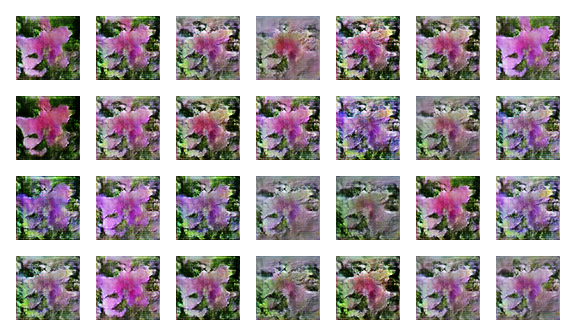

In [ ]:
import IPython
IPython.display.Image('/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/output_64_character_extended/train-1.png')

In [ ]:
test_image("this flower is yellow in color with oval shaped petals",2)

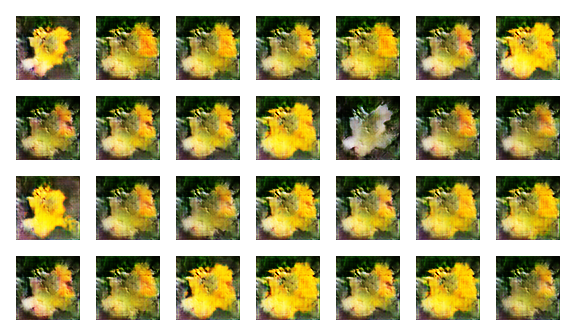

In [ ]:
import IPython
IPython.display.Image('/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/output_64_character_extended/train-2.png')

In [ ]:
test_image("this flower is pink in color with oval shaped petals",3)

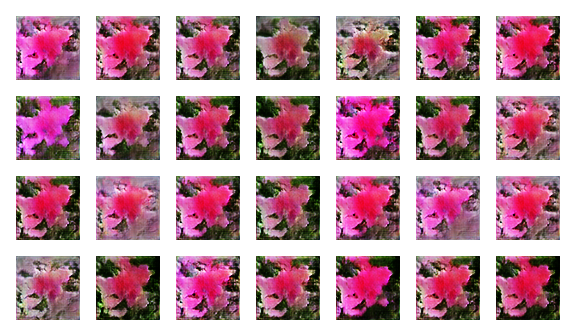

In [ ]:
import IPython
IPython.display.Image('/content/drive/Shareddrives/D4NLP Project/flowers data/flowers/output_64_character_extended/train-3.png')

#Installing LIB


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.1 MB/s eta 0:00:00


In [ ]:
!pip install diffusers[transformers]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 13.8 MB/s eta 0:00:00


In [ ]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.3 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=3c8b7e51ebdeecd5f73e9a713942fa6cf774ea037e077ba93757b52ad582c78e
  Stored in directory: /root/.cache/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2023-04-05 03:00:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  16.4MB/s    in 0.8s    

2023-04-05 03:00:13 (16.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
import transformers
from diffusers import StableDiffusionPipeline
import torch
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# UI


In [ ]:

prompt = "flower pink oval shaped petals"

image = pipe(prompt).images[0]  

image = image.resize((64,64))

image.save("img1.png")

  0%|          | 0/50 [00:00<?, ?it/s]

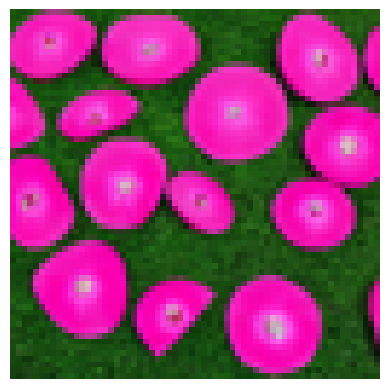

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:

prompt = "oval shaped petals flowers which is pink in color"

image = pipe(prompt).images[0]  
image = image.resize((64,64))

image.save("img2.png")

  0%|          | 0/50 [00:00<?, ?it/s]

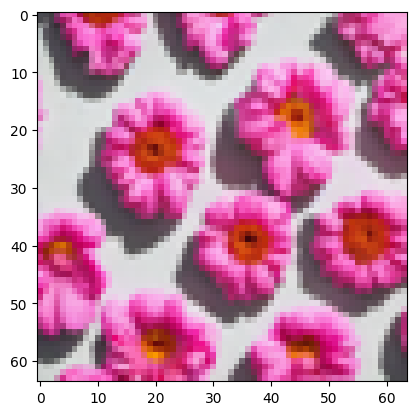

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(image)
#plt.axis("off")
plt.show()